In [1]:
import cfgrib
import numpy as np
import matplotlib.pyplot as plt
import sys
import warnings
warnings.simplefilter("ignore")  # check those
sys.path.append("..")

from baselines.data_processor import DataProcessor
from baselines.exp_smoothing.smoothing import SmoothingPredictor

c:\Users\iwama\Desktop\Maciej\Eng\meteoapp-data\venv\lib\site-packages\gribapi\__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.27.0
  warnings.warn(


In [2]:
data, feature_list = DataProcessor.load_data("../data2022-2div.grib")
s = 3
fh = 2

processor = DataProcessor(data)
X, y = processor.preprocess(s, fh, use_neighbours=False)
X_train, X_test, y_train, y_test = processor.train_test_split(X, y)

In [3]:
X_train, y_train = X_train[-100:], y_train[-100:]
X_test, y_test = X_test[:5], y_test[:5]

In [4]:
X_test.shape

(5, 32, 48, 3, 6)

t2m => RMSE:  5.01302; SE: 0.07094374190654301
tcc => RMSE:  5.25591; SE: 0.4061970465494717
u10 => RMSE:  0.41824; SE: 0.006113593472682075
v10 => RMSE:  3.70309; SE: 0.05098664119626722
tp => RMSE:  2.63828; SE: 0.039731223760815414
sp => RMSE:  0.00061; SE: 8.699595490738789e-06


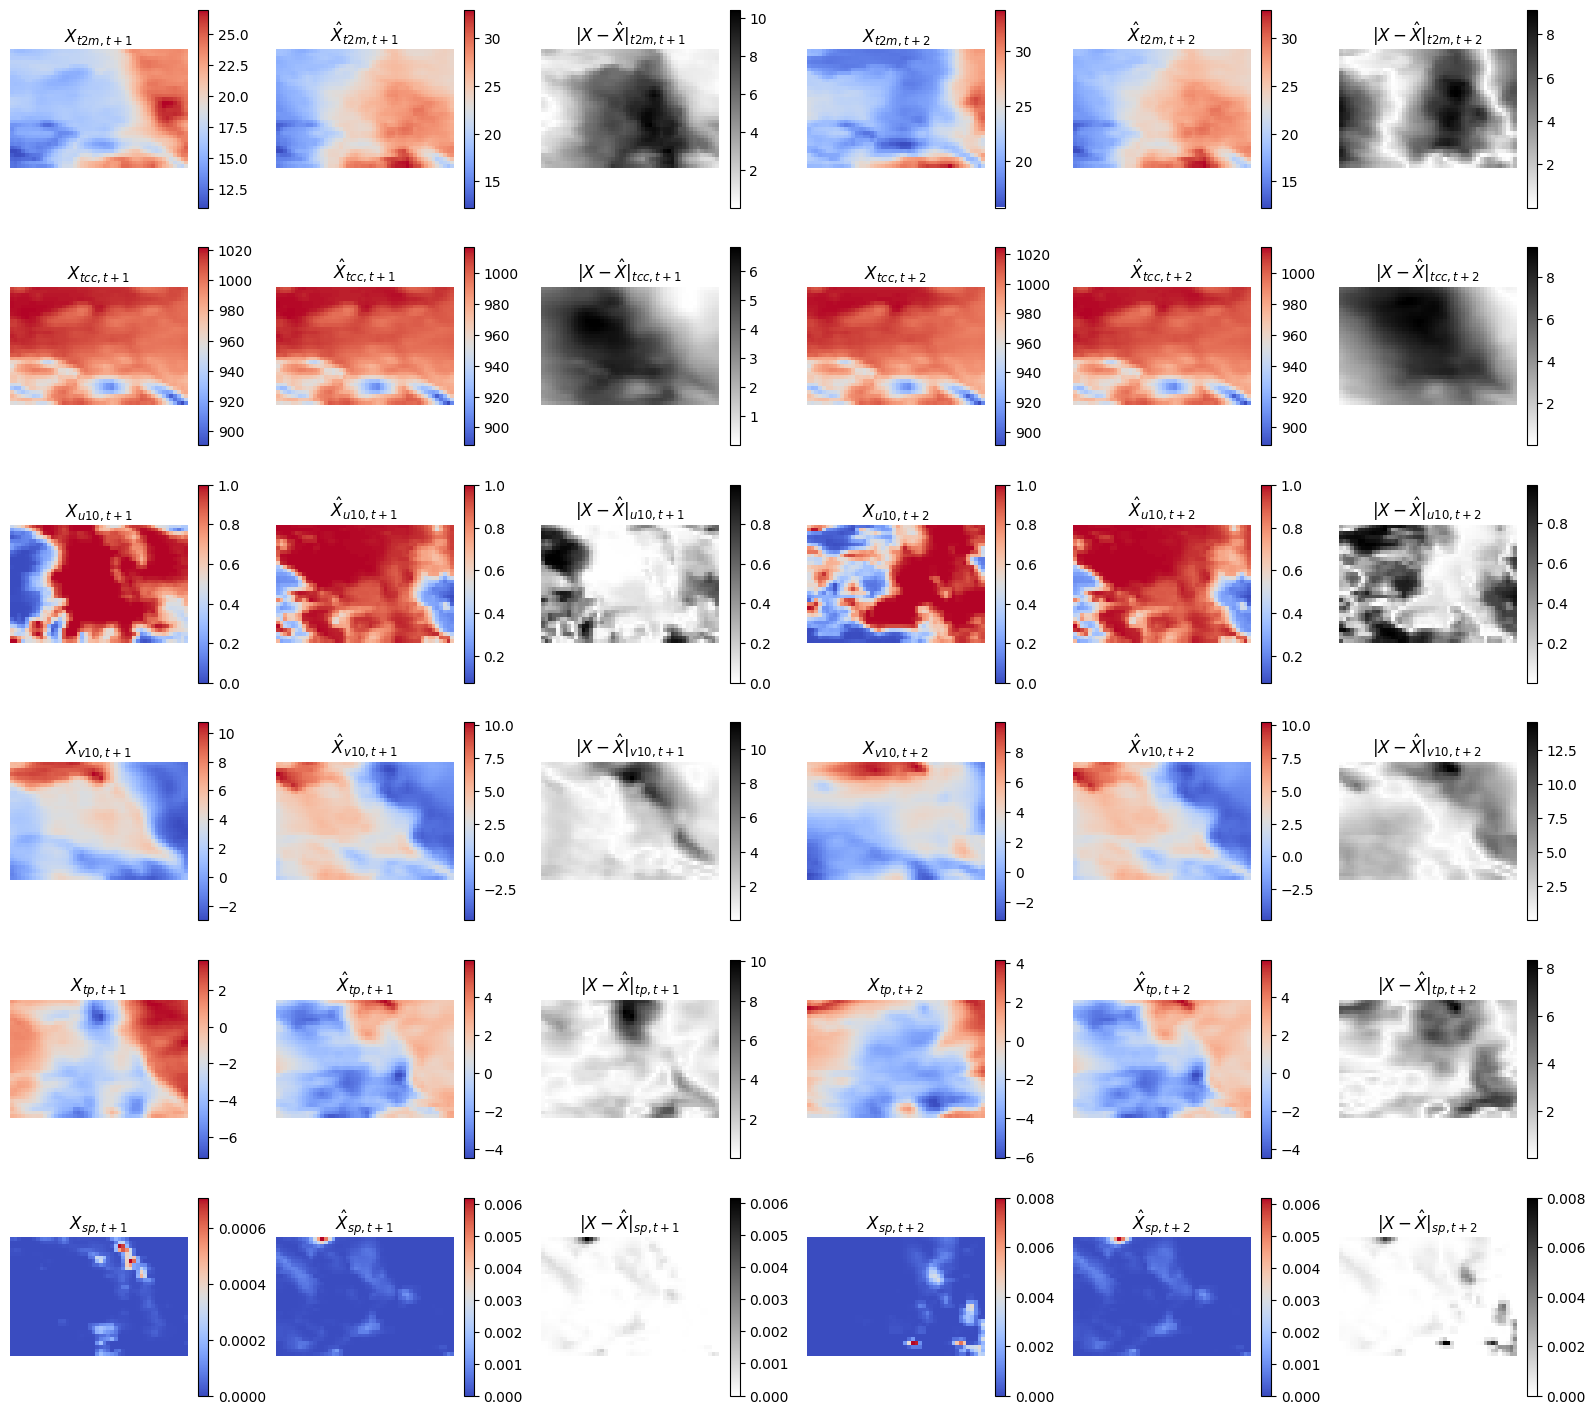

Evaluation metrics for entire test set:
t2m => RMSE: 4.455; SE: 0.03038581345851162
tcc => RMSE: 3.22; SE: 0.18584413977588035
u10 => RMSE: 0.394; SE: 0.003245026284959683
v10 => RMSE: 3.134; SE: 0.020788331988300147
tp => RMSE: 2.227; SE: 0.01739462096646012
sp => RMSE: 0.001; SE: 3.135623115976806e-06



 68.42300391197205 [s]


In [9]:
from time import time 
start = time()

predictor = SmoothingPredictor(X.shape, fh, feature_list, 'simple')
_ = predictor.predict_and_evaluate(X_test, y_test, max_samples=1)
print("\n======================================\n")

stop = time()
print('\n', stop-start, '[s]')

In [6]:
"""
TEST SET RESULTS FOR DIFFERENT IMPLEMENTATIONS:
a) no training, just 'estimated' init_method (heuristic does not work - min. 10 observations):
SIMPLE:
t2m => RMSE: 3.966; SE: 0.014918221828480993
sp => RMSE: 2.486; SE: 0.07342948176959976
tcc => RMSE: 0.333; SE: 0.0011988784087137597
u10 => RMSE: 2.022; SE: 0.008577662189566968
v10 => RMSE: 1.866; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-0
    time: ~11 minutes (30 examples => ~20s per example)
HOLT:
t2m => RMSE: 6.814; SE: 0.014918221828480993
sp => RMSE: 2.461; SE: 0.07342948176959976
tcc => RMSE: 0.521; SE: 0.0011988784087137597
u10 => RMSE: 2.67; SE: 0.008577662189566968
v10 => RMSE: 2.391; SE: 0.00904395633958023
tp => RMSE: 0.001; SE: 9.430597444098186e-07
    time ~57 minutes (30 examples => ~2 minutes per example) TOO SLOW!
=============================
b) All in one (not pixel by pixel):
SIMPLE
t2m => RMSE: 4.446; SE: 0.014918221828480993
sp => RMSE: 22.368; SE: 0.07342948176959976
tcc => RMSE: 0.394; SE: 0.0011988784087137597
u10 => RMSE: 3.239; SE: 0.008577662189566968
v10 => RMSE: 3.142; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-07
HOLT:
t2m => RMSE: 6.666; SE: 0.014918221828480993
sp => RMSE: 28.726; SE: 0.07342948176959976
tcc => RMSE: 7.09; SE: 0.0011988784087137597
u10 => RMSE: 253.311; SE: 0.008577662189566968
v10 => RMSE: 115.572; SE: 0.00904395633958023
tp => RMSE: 0.006; SE: 9.430597444098186e-07
    time: 15s
HOLT_WINTERS:
t2m => RMSE: 5.381; SE: 0.014918221828480993
sp => RMSE: 22.364; SE: 0.07342948176959976
tcc => RMSE: 0.418; SE: 0.0011988784087137597
u10 => RMSE: 3.42; SE: 0.008577662189566968
v10 => RMSE: 3.009; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-07

W SKRÓCIE - trzeba zrobić dla każdego piksela osobno, jest od połowy do znacznie lepiej
"""
0

0

In [7]:
'''
SIMPLE @ 0.05
=======================================
Evaluation metrics for entire test set:
=======================================
t2m => RMSE: 4.055; SE: 0.014918221828480993
sp => RMSE: 4.46; SE: 0.07342948176959976
tcc => RMSE: 0.385; SE: 0.0011988784087137597
u10 => RMSE: 2.824; SE: 0.008577662189566968
v10 => RMSE: 2.838; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-07

======================================

SIMPLE @ 0.1
=======================================
Evaluation metrics for entire test set:
=======================================
t2m => RMSE: 3.904; SE: 0.014918221828480993
sp => RMSE: 4.281; SE: 0.07342948176959976
tcc => RMSE: 0.37; SE: 0.0011988784087137597
u10 => RMSE: 2.711; SE: 0.008577662189566968
v10 => RMSE: 2.717; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-07

======================================

SIMPLE @ 0.2
=======================================
Evaluation metrics for entire test set:
=======================================
t2m => RMSE: 3.687; SE: 0.014918221828480993
sp => RMSE: 3.95; SE: 0.07342948176959976
tcc => RMSE: 0.345; SE: 0.0011988784087137597
u10 => RMSE: 2.512; SE: 0.008577662189566968
v10 => RMSE: 2.5; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-07

======================================

SIMPLE @ 0.3
=======================================
Evaluation metrics for entire test set:
=======================================
t2m => RMSE: 3.572; SE: 0.014918221828480993
sp => RMSE: 3.653; SE: 0.07342948176959976
tcc => RMSE: 0.329; SE: 0.0011988784087137597
u10 => RMSE: 2.348; SE: 0.008577662189566968
v10 => RMSE: 2.318; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-07

======================================

SIMPLE @ 0.5
=======================================
Evaluation metrics for entire test set:
=======================================
t2m => RMSE: 3.57; SE: 0.014918221828480993
sp => RMSE: 3.159; SE: 0.07342948176959976
tcc => RMSE: 0.315; SE: 0.0011988784087137597
u10 => RMSE: 2.113; SE: 0.008577662189566968
v10 => RMSE: 2.045; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-07

======================================

SIMPLE @ 0.6
=======================================
Evaluation metrics for entire test set:
=======================================
t2m => RMSE: 3.64; SE: 0.014918221828480993
sp => RMSE: 2.958; SE: 0.07342948176959976
tcc => RMSE: 0.316; SE: 0.0011988784087137597
u10 => RMSE: 2.036; SE: 0.008577662189566968
v10 => RMSE: 1.949; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-07

======================================

SIMPLE @ 0.8
=======================================
Evaluation metrics for entire test set:
=======================================
t2m => RMSE: 3.838; SE: 0.014918221828480993
sp => RMSE: 2.637; SE: 0.07342948176959976
tcc => RMSE: 0.326; SE: 0.0011988784087137597
u10 => RMSE: 1.94; SE: 0.008577662189566968
v10 => RMSE: 1.823; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-07

======================================
'''
0

0

In [8]:
'''
temp = 0.3-0.5
tcc = 0.6
sp, wiatr = 0.8
RESULTS:
t2m => RMSE: 3.54; SE: 0.014918221828480993
sp => RMSE: 2.637; SE: 0.07342948176959976
tcc => RMSE: 0.316; SE: 0.0011988784087137597
u10 => RMSE: 1.94; SE: 0.008577662189566968
v10 => RMSE: 1.823; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-07
    time: 250 s

=======================================
Evaluation metrics for entire test set:
=======================================
t2m => RMSE: 2.535; SE: 0.00722035292861406
sp => RMSE: 2.996; SE: 0.026186777730342913
tcc => RMSE: 0.282; SE: 0.00034068190903559453
u10 => RMSE: 1.9; SE: 0.003557221413840321
v10 => RMSE: 1.608; SE: 0.002911139152650286
tp => RMSE: 0.0; SE: 2.454296631825405e-07

======================================
Total time taken:
 2679.79207611084 [s] <= 286 examples (45 minutes)
'''

'\ntemp = 0.3-0.5\ntcc = 0.6\nsp, wiatr = 0.8\nRESULTS:\nt2m => RMSE: 3.54; SE: 0.014918221828480993\nsp => RMSE: 2.637; SE: 0.07342948176959976\ntcc => RMSE: 0.316; SE: 0.0011988784087137597\nu10 => RMSE: 1.94; SE: 0.008577662189566968\nv10 => RMSE: 1.823; SE: 0.00904395633958023\ntp => RMSE: 0.0; SE: 9.430597444098186e-07\n    time: 250 s\n\n=======================================\nEvaluation metrics for entire test set:\n=======================================\nt2m => RMSE: 2.535; SE: 0.00722035292861406\nsp => RMSE: 2.996; SE: 0.026186777730342913\ntcc => RMSE: 0.282; SE: 0.00034068190903559453\nu10 => RMSE: 1.9; SE: 0.003557221413840321\nv10 => RMSE: 1.608; SE: 0.002911139152650286\ntp => RMSE: 0.0; SE: 2.454296631825405e-07\n\n======================================\nTotal time taken:\n 2679.79207611084 [s] <= 286 examples (45 minutes)\n'